## Reading script for supplementary data
This jupyter notebook demonstrates how to read in the circular and eccentric data cubes. Then we provide a simple example which makes use of the data to compute the evolution trcaks for orbital elements.  

In [11]:
import numpy as np

# Output directory
outputdir = './'

# Set the circular data directory
supp_dir_c = outputdir+"circular/"

# Set the eccentric data directory
supp_dir_e = outputdir+"eccentric/"

## Read in the Circular Data
Here we will read in the circular data discussed in paper section 3.

In [12]:
# Read in the parameter lists
param_file = open(supp_dir_c+'parameters.out', 'r')
q_list_read = np.array(param_file.readline().split()).astype(float)
p_list_read = np.array(param_file.readline().split()).astype(float)
h_list_read = np.array(param_file.readline().split()).astype(float)
param_file.close()

# Defines the shape of the torque data
data_shape = (len(q_list_read),len(p_list_read),len(h_list_read))

# Extract the circular net torque, first including, then excluding the m=1 mode
Tcir_net_m1 = np.reshape(np.loadtxt(supp_dir_c+'t_net_m1.out'),data_shape)
Tcir_net_m2 = np.reshape(np.loadtxt(supp_dir_c+'t_net_m2.out'),data_shape)

# Extract the circular Lindblad torque
Tcir_L_m1 = np.reshape(np.loadtxt(supp_dir_c+'t_l_m1.out'),data_shape)
Tcir_L_m2 = np.reshape(np.loadtxt(supp_dir_c+'t_l_m2.out'),data_shape)

# Extract the circular corotation torque
Tcir_C_m1 = np.reshape(np.loadtxt(supp_dir_c+'t_c_m1.out'),data_shape)
Tcir_C_m2 = np.reshape(np.loadtxt(supp_dir_c+'t_c_m2.out'),data_shape)

## Read in the Eccentric Data
Here we will read in the eccentric data discussed in paper section 4.

In [13]:
# Read in the parameter lists
param_file = open(supp_dir_e+'parameters.out', 'r')
q_list = np.array(param_file.readline().split()).astype(float)
p_list = np.array(param_file.readline().split()).astype(float)
h_list = np.array(param_file.readline().split()).astype(float)
e_list = np.array(param_file.readline().split()).astype(float)
param_file.close()

# This defines the shape of the torque data
data_shape = (len(q_list),len(p_list),len(h_list),len(e_list))

# Extract the net torque
Tecc_net = np.reshape(np.loadtxt(supp_dir_e+'t_net.out'), data_shape)
# Extract the Lindblad torque
Tecc_L = np.reshape(np.loadtxt(supp_dir_e+'t_l.out'), data_shape)
# Extract the corotation torque
Tecc_C = np.reshape(np.loadtxt(supp_dir_e+'t_c.out'), data_shape)

# Extract the angular momentum damping timescale
tau_L_inv = np.reshape(np.loadtxt(supp_dir_e+'tau_L_inv.out'), data_shape)
# Extract the semi-major axis damping timescale
tau_a_inv = np.reshape(np.loadtxt(supp_dir_e+'tau_a_inv.out'), data_shape)
# Extract the eccentricity damping timescale
tau_e_inv = np.reshape(np.loadtxt(supp_dir_e+'tau_e_inv.out'), data_shape)

# Example migration plot
This plot will recreate Fig. 10 from the paper.

In [14]:
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Set the disc parameters
Sigma0 = 0.001          # In units of Mstar/Rref^2
Omega0 = 2*np.pi        # In units of 1/Tref
hp = 0.062              # Reference aspect ratio at Rref
Mp = 3.e-6              # In units of stellar mass
Mstar = 1.0             # In units of stellar mass
a0 = 1.0                # Initial reference semi-major axis in units of Rref
Msun = 1.989e33  # Mass of sun in grams
AU = 1.496e13    # Astronomical unit in cm

In [15]:
# Define functions which set the migration rates in (a,e) as a function of
#  (a,e,h(a)) with fixed parameters (q,p).

# Set the bounds error flag if interpolation goes out of range
BOUNDS_ERR = True    
# Set the fill value for out of range interpolation          
FILL_VAL = None                 

# Set the characteristic flux scaling
def Fj_scale(a,qi,pi):
    """
    Defines the characteristic flux quantity as a function of a.
    """
    q = q_list[qi]
    p = p_list[pi]
    Sigma = Sigma0*pow(a/a0,-p)
    Omega = Omega0*pow(a/a0,-1.5)
    ha = hp*pow(a/a0,(1.-q)/2.)
    fj0 = Sigma*pow(a/a0,4)*pow(Omega,2)*pow(ha,-3)*pow(Mp/Mstar,2)
    return fj0

def invtau_scale(a,qi,pi):
    """
    Defines the characteristic inverse timescale as a function of a.
    """
    q = q_list[qi]
    p = p_list[pi]
    Sigma = Sigma0*pow(a/a0,-p)
    Omega = Omega0*pow(a/a0,-1.5)
    ha = hp*pow(a/a0,(1.-q)/2.)
    fj0 = Sigma*pow(a/a0,4)*pow(Omega,2)*pow(ha,-3)*pow(Mp/Mstar,2)

    return fj0/(Mp*Omega*pow(a/a0,2))

def d_ae_dtFunc(a,e,qi,pi):
    """
    Computes the migration rate of a.
    """
    q = q_list[qi]
    p = p_list[pi]

    # Compute the local scale height at the current location
    ha = hp*pow(a/a0,(1.-q)/2.)

    # Interpolate tau_inv timescales for the value of e
    tau_a_inv_interp = RegularGridInterpolator((h_list,e_list),tau_a_inv[qi,pi],bounds_error=BOUNDS_ERR,fill_value=FILL_VAL)
    tau_e_inv_interp = RegularGridInterpolator((h_list,e_list),tau_e_inv[qi,pi],bounds_error=BOUNDS_ERR,fill_value=FILL_VAL)

    # Compute the charcateristic scales
    tinv_scale = invtau_scale(a,qi,pi)
    dadt = -tinv_scale*a*tau_a_inv_interp((ha,e))
    dedt = -tinv_scale*e*tau_e_inv_interp((ha,e))

    return dadt,dedt

def d_L_dtFunc(a,e,qi,pi):

    q = q_list[qi]
    p = p_list[pi]

    # Compute the local scale height at the current location
    ha = hp*pow(a,(1.-q)/2.)

    # Now find the regular grid interpolation
    tau_L_inv_interp = RegularGridInterpolator((h_list,e_list),tau_L_inv[qi,pi],bounds_error=BOUNDS_ERR,fill_value=FILL_VAL)

    # Compute the angular momentum damping rate
    fj_scale = Fj_scale(a,qi,pi)
    dLdt = -fj_scale*pow(1-e**2,0.5)*tau_L_inv_interp((ha,e))

    return dLdt

In [16]:
# Set up the integrator functions

def RHSFunc(t,y,qi,pi):
    """
    Wrapper function for the odeint solver.
    """

    a = y[0]
    e = y[1]

    dadt,dedt = d_ae_dtFunc(a,e,qi,pi)

    return [dadt,dedt]

# Set integrator exception events to track if the planet reaches the inner boundary
def eventaFunc(t,y,qi,pi):
    """
    Event function to track if the planet reaches the inner boundary.
    """
    amin = 0.05
    return y[0]-amin

def eventeFunc(t,y,qi,pi):
    """
    Event function to track if the planet reaches zero eccentricity.
    """
    emin = 0.0
    return y[1]-emin

def eventhFunc(t,y,qi,pi):
    """
    Event function to track if the planet reaches minimum value of h in data cube.
    """
    hmin = 0.06
    return hp*pow(y[0]/a0,(1.-q_list[qi])/2.)-hmin

In [17]:
# Now integrate the orbital elements from a set of initial conditions

# Set the initial conditions
ainit = 1.0
einit = 0.12

# Set the time range
tstart = 0
tend = 800
teval = np.linspace(tstart,tend,1000)

# Set the disc q and p exponents we want to investigate
qis = [0,0,3]
pis = [0,3,0]

METHOD = 'RK45'                 # Set the integration method
RTOL = 1e-6                     # Set the relative tolerance
eventeFunc.terminal = True      # Set the integration to terminate if the event is reached

# Now integrate system of odes
print('Sol 1')
sol1 = solve_ivp(RHSFunc, [tstart,tend], [ainit,einit], args=(qis[0],pis[0]), method=METHOD,t_eval=teval,events=[eventaFunc,eventeFunc,eventhFunc],rtol=RTOL)
print('Sol 2')
sol2 = solve_ivp(RHSFunc, [tstart,tend], [ainit,einit], args=(qis[1],pis[1]), method=METHOD,t_eval=teval,events=[eventaFunc,eventeFunc,eventhFunc],rtol=RTOL)
print('Sol 3')
sol3 = solve_ivp(RHSFunc, [tstart,tend], [ainit,einit], args=(qis[2],pis[2]), method=METHOD,t_eval=teval,events=[eventaFunc,eventeFunc,eventhFunc],rtol=RTOL)

Sol 1
Sol 2
Sol 3


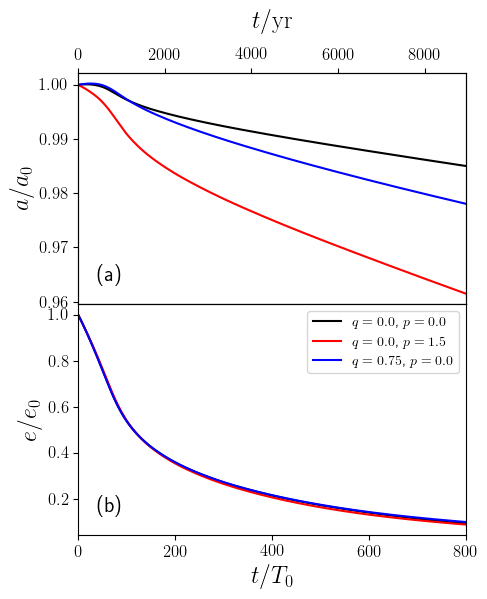

In [18]:
# Plot the figure

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.titlesize': 'x-large'}
pylab.rcParams.update(params)
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(2,1,figsize=(5,6))
ax[0].plot(sol1.t,sol1.y[0]/ainit,color='k')
ax[0].plot(sol2.t,sol2.y[0]/ainit,color='r')
ax[0].plot(sol3.t,sol3.y[0]/ainit,color='b')
ax[0].set_ylabel(r'$a/a_0$')
ax[0].set_xticks([])
ax[0].text(0.05,0.1,'(a)',transform=ax[0].transAxes,fontsize=15,color='k')
ax[0].set_xlim([tstart,tend])


ax[1].plot(sol1.t,sol1.y[1]/einit, label=r'$q={0}$, $p={1}$'.format(q_list[qis[0]],p_list[pis[0]]), color='k')
ax[1].plot(sol2.t,sol2.y[1]/einit, label=r'$q={0}$, $p={1}$'.format(q_list[qis[1]],p_list[pis[1]]), color='r')
ax[1].plot(sol3.t,sol3.y[1]/einit, label=r'$q={0}$, $p={1}$'.format(q_list[qis[2]],p_list[pis[2]]), color='b')
ax[1].set_xlabel(r'$t/T_{0}$')
ax[1].set_ylabel(r'$e/e_0$')
ax[1].legend(fontsize=10)
ax[1].text(0.05,0.1,'(b)',transform=ax[1].transAxes,fontsize=15,color='k')
ax[1].set_xlim([tstart,tend])

axtop = ax[0].twiny()
def Time_in_Yrs(Torbs,RAU,M_in_solar):
    return Torbs*pow(RAU,3/2)*pow(M_in_solar,-1/2)

axtop.set_xlim([Time_in_Yrs(tstart,5,1),Time_in_Yrs(tend,5,1)])
axtop.set_xlabel(r'$t/\textrm{yr}$',labelpad=15)

plt.subplots_adjust(hspace=0.0)

plt.show()
plt.close()